In [ ]:
import torch
import numpy as np
from typing import Optional
import shutil
from dataclasses import dataclass
import glob
import json
from pathlib import Path
from typing import Dict, List, Optional

from PIL import Image
import os

import numpy as np
from scipy.spatial.transform import Rotation as R

from benchmarks.preprocess_data import Resolution, Frame, glob_for_frames, get_resolution_from_frames

def matrix_to_quaternion(matrix):
    R_matrix = matrix[:3, :3]
    r = R.from_matrix(R_matrix)
    q = r.as_quat(scalar_first=True)  # Convert to quaternion (w,x,y,z)
    t = matrix[:3, 3]
    return q,t

In [ ]:
def convert_vggt_poses_to_ace_poses(data_pattern:str, pose_file: str, intrinsics_file: str, intrinsics_type:str, confidence_depth_file: Optional[str], confidence_point_file: Optional[str], output_file:str) -> None:
    
    c2ws = np.loadtxt(pose_file).reshape(-1,3,4)
    bottom = np.array([[0, 0, 0, 1]]).reshape(1,1,4)
    c2ws = np.concatenate([c2ws, bottom.repeat(c2ws.shape[0], axis=0)], axis=1)
    w2cs = np.linalg.inv(c2ws)


    qs,ts = [],[]
    for w2c in w2cs:
        q,t = matrix_to_quaternion(w2c)
        qs.append(q)
        ts.append(t)

    dataset_frames = glob_for_frames(data_pattern)
    sorted_frames = sorted(dataset_frames, key=lambda x: x.rgb_path)

    K33 = np.loadtxt(intrinsics_file).reshape(-1,3,3)

    K_h,K_w = K33[0, 1, 2]*2, K33[0, 0, 2]*2
    resolution = get_resolution_from_frames(frames=dataset_frames)

    scale_h, scale_w = resolution.height / K_h, resolution.width / K_w
    K33[:, 0, 2] *= scale_w
    K33[:, 1, 2] *= scale_h
    K33[:, 0, 0] *= scale_w
    K33[:, 1, 1] *= scale_h

    if confidence_depth_file is not None:
        confidence_depth = np.loadtxt(confidence_depth_file).reshape(-1, 1)
    if confidence_point_file is not None:
        confidence_point = np.loadtxt(confidence_point_file).reshape(-1, 1)
    
    confidences = []
    if confidence_depth_file is  None and confidence_point_file is  None:
        confidences = [1001 for _ in range(len(dataset_frames))]

    # print(confidences)
    with open(output_file, 'w') as f:
        for frame,q,t,k,c in zip(dataset_frames, qs,ts, K33, confidences):
            print(f"Processing frame: {frame.rgb_path}")
            f.write(f"{frame.rgb_path} {q[0]} {q[1]} {q[2]} {q[3]} {t[0]} {t[1]} {t[2]} {k[0,0]} {c}\n")



In [ ]:
import os
def update_cam_pose_after_ba(json_before_ba, json_after_ba_train,json_after_ba_test: Optional[str], output_json):
    """
    Update the camera poses in the JSON file after bundle adjustment.
    """
    with open(json_before_ba, 'r') as f:
        data_before = json.load(f)

    with open(json_after_ba_train, 'r') as f:
        data_train_after = json.load(f)
    if json_after_ba_test is not None:
        with open(json_after_ba_test, 'r') as f:
            data_test_after = json.load(f)

    # Update the camera poses
    prefix = os.path.split(data_before["frames"][0]["file_path"])[0]

    transform_dict = {}
    for i in range(len(data_train_after)):
        # data_train_after[i]["file_path"] = os.path.join(prefix, os.path.basename(data_train_after[i]["file_path"]))
        transform_dict[data_train_after[i]["file_path"]] = data_train_after[i]["transform"]
    if json_after_ba_test is not None:
        for i in range(len(data_test_after)):
            # data_test_after[i]["file_path"] = os.path.join(prefix, os.path.basename(data_test_after[i]["file_path"]))
            transform_dict[data_test_after[i]["file_path"]] = data_test_after[i]["transform"]

    for i in range(len(data_before["frames"])):
        del data_before["frames"][i]["transform_matrix"]
        data_before["frames"][i]["transform_matrix"] = transform_dict[data_before["frames"][i]["file_path"]]
        data_before["frames"][i]["transform_matrix"].append([0.0,0.0,0.0,1.0])


    # Save the updated JSON
    with open(output_json, 'w') as f:
        json.dump(data_before, f, indent=4)

In [ ]:
def convert_opencv_to_opengl(opencv_mat, transform_type='world2cam'):
    # If the input matrix is cam2world, invert it to get world2cam
    if transform_type == 'cam2world':
        opencv_mat = np.linalg.inv(opencv_mat)

    # This matrix converts between opengl (x right, y up, z back) and cv-style (x right, y down, z forward) coordinates
    # For nerfstudio, we want opengl coordinates
    coord_transform = np.array([
        [1,  0,  0,  0],
        [0, -1,  0,  0],
        [0,  0, -1,  0],
        [0,  0,  0,  1]
    ])

    # NB for the following we expect the mat to be in world2cam format
    opengl_mat = coord_transform @ opencv_mat

    if transform_type == 'cam2world':
        opengl_mat = np.linalg.inv(opengl_mat)

    return opengl_mat

def convert_opengl_to_opencv(opengl_mat, transform_type='world2cam'):
    # If the input matrix is cam2world, invert it to get world2cam
    if transform_type == 'cam2world':
        opengl_mat = np.linalg.inv(opengl_mat)

    # This matrix converts between opengl (x right, y up, z back) and cv-style (x right, y down, z forward) coordinates
    # For nerfstudio, we want opengl coordinates
    coord_transform = np.array([
        [1,  0,  0,  0],
        [0, -1,  0,  0],
        [0,  0, -1,  0],
        [0,  0,  0,  1]
    ])

    # NB for the following we expect the mat to be in world2cam format
    opencv_mat = coord_transform @ opengl_mat

    if transform_type == 'cam2world':
        opencv_mat = np.linalg.inv(opencv_mat)

    return opencv_mat

def convert_nerf_blender_format_to_vggt_format(json_file_path, output_file_path):

    with open(json_file_path, 'r') as f:
        transforms_json = json.load(f)
    transforms_json["frames"] = sorted(transforms_json["frames"], key=lambda x: x["file_path"])
    c2ws_opengl = [frame["transform_matrix"] for frame in transforms_json['frames']]
    c2ws_opencv = [convert_opengl_to_opencv(c2w, transform_type="cam2world") for c2w in c2ws_opengl]
    # c2ws_opencv = [np.linalg.inv(w2c) for w2c in w2cs_opencv]


    with open(output_file_path, 'w') as f:
        for c2w,fra in zip(c2ws_opencv,transforms_json["frames"]):
            print(fra["file_path"])
            f.write(f"{c2w[0][0]} {c2w[0][1]} {c2w[0][2]} {c2w[0][3]} {c2w[1][0]} {c2w[1][1]} {c2w[1][2]} {c2w[1][3]} {c2w[2][0]} {c2w[2][1]} {c2w[2][2]} {c2w[2][3]}\n")


In [ ]:
reconstruction_path = Path("/mnt/jfs/hengli/projects/vggt_workspace/acezero/benchmark_output/vggt_ba_1e-31e-5_2/7scenes_test_30k_50_150_300/pumpkin/nerf_data")
ba_run_path = Path("/mnt/jfs/hengli/projects/vggt_workspace/acezero/benchmark_output/vggt_ba_1e-31e-5_2/7scenes_test_30k_50_150_300/pumpkin/nerf_data/ba/nerfacto/run")
output_path = Path("/mnt/jfs/hengli/projects/vggt_workspace/acezero/benchmark_output/vggt_ba_1e-31e-5_2/7scenes_test_30k_50_150_300/pumpkin/nerf_data")

json_before_ba = reconstruction_path / "transforms_before_ba.json"
json_after_ba_train = ba_run_path / "transforms_train.json"
# json_after_ba_test = Path("/mnt/jfs/hengli/projects/vggt_workspace/acezero/benchmark_output/vggt_ba_1e-31e-5_2/7scenes/stairs/nerf_data/ba/nerfacto/run/transforms_eval.json")
output_json = output_path/"transforms.json"
update_cam_pose_after_ba(json_before_ba, json_after_ba_train,None, output_json)
output_json = output_path/"transforms.json"
data_path = Path("/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/7scenes_test_30k_50_150_300/pumpkin")
convert_nerf_blender_format_to_vggt_format(output_json, data_path / "pred_ba.txt")

In [ ]:
json_before = "/mnt/jfs/hengli/projects/vggt_workspace/acezero/data/bicycle/benchmark_barf/nerf_data/transforms.json"
json_after_train = "/mnt/jfs/hengli/projects/vggt_workspace/acezero/data/bicycle/benchmark_barf/nerf_data/nerf_data/nerfacto/2025-07-23_095351/transforms_train.json"
json_after_test = "/mnt/jfs/hengli/projects/vggt_workspace/acezero/data/bicycle/benchmark_barf/nerf_data/nerf_data/nerfacto/2025-07-23_095351/transforms_eval.json"
update_cam_pose_after_ba(json_before_ba=json_before,
                         json_after_ba_train=json_after_train,
                         json_after_ba_test=json_after_test,
                         output_json="/mnt/jfs/hengli/projects/vggt_workspace/acezero/data/bicycle/benchmark_barf/after_ba/transforms.json")

In [ ]:
prefix = os.path.basename("/mnt/jfs/hengli/projects/vggt_workspace/acezero/data/bicycle/benchmark_barf/nerf_data/images_2/benchmark_datasets_mip360_bicycle_images_4__DSC8679.JPG")

In [ ]:
import shutil
from dataclasses import dataclass
import glob
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple

from PIL import Image

import numpy as np
from scipy.spatial.transform import Rotation as R



@dataclass
class Resolution:
    height: int
    width: int

    def __post_init__(self):
        assert self.height > 0
        assert self.width > 0

    def flip(self):
        return Resolution(height=self.width, width=self.height)

    def __hash__(self) -> int:
        return hash((self.height, self.width))


@dataclass
class Frame:
    # Represents a single RGB frame
    rgb_path: Path

    def get_image_resolution(self) -> Resolution:
        im = Image.open(self.rgb_path)
        return Resolution(height=im.height, width=im.width)

    def load_image(self) -> Image.Image:
        return Image.open(self.rgb_path)


def preprocess_json_frames(ace_poses_path: Path, dataset_frames: List[Frame]) -> List[Dict]:
    # Takes a path to a file containing some ACE-format poses, and a dataset as represented by a list of Frame objects,
    # and processes them into some 'transforms.json'-style frames.

    poses = parse_ace_poses_file(ace_poses_path)
    json_frames = convert_ace_poses_to_nerf_blender_frames_json(poses)
    resolution = get_resolution_from_frames(frames=dataset_frames)
    json_frames_lookup: dict[str, dict] = {frame['file_path']: frame for frame in json_frames}

    # We iterate over all frames in the dataset, rather than the frames we got from the poses file, because some frames
    # might not have poses; in such cases, the frame still needs to go into the transforms.json file, but with an
    # identity pose.
    json_frames_preprocessed = []
    for dataset_frame in dataset_frames:
        print('Processing frame', dataset_frame.rgb_path)

        # Match this dataset frame with the corresponding pose from the poses file (if there is one there)
        json_frame = json_frames_lookup.get(str(dataset_frame.rgb_path))
        if json_frame is None:
            # If no pose was provided for this frame, we will use an identity pose
            print(f'WARNING: No pose found for frame {dataset_frame.rgb_path}; using identity pose instead!')
            json_frame = make_json_frame_for_missing_pose(dataset_frame, resolution)

        # We expect to have focal length info, and we also assume elsewhere that they are equal
        # so we should verify this explicitly:
        assert json_frame['fl_x'] == json_frame['fl_y'], 'Expected focal lengths to be equal'

        # Now make an intrinsics dict from the focal length for this frame:
        intrinsics = make_intrinsics_dict_from_focal(resolution=resolution, focal_length=json_frame['fl_x'])

        print('Intrinsics for frame are', intrinsics)
        json_frame.update(intrinsics)
        json_frames_preprocessed.append(json_frame)
    return json_frames_preprocessed

def convert_nerf_blender_format_to_vggt_format(json_file_path, output_file_path):

    with open(json_file_path, 'r') as f:
        transforms_json = json.load(f)
    
    w2cs_opengl = [frame["transform_matrix"] for frame in transforms_json['frames']]
    w2cs_opencv = [convert_opencv_to_opengl(w2c,) for w2c in w2cs_opengl]
    c2ws_opencv = [np.linalg.inv(w2c) for w2c in w2cs_opencv]


    with open(output_file_path, 'w') as f:
        for c2w in c2ws_opencv:
            f.write(f"{c2w[0][0]} {c2w[0][1]} {c2w[0][2]} {c2w[0][3]} {c2w[1][0]} {c2w[1][1]} {c2w[1][2]} {c2w[1][3]} {c2w[2][0]} {c2w[2][1]} {c2w[2][2]} {c2w[2][3]}\n")

def convert_ace_zero_to_nerf_blender_format(poses_path: Path, images_glob_pattern: str, output_path: Path,
                                            split_file_path: Optional[Path] = None) -> None:
    """
    Converts a dataset in the Ace Zero format to a format suitable for ingestion by Nerfstudio.
    """
    dataset_frames = glob_for_frames(images_glob_pattern=images_glob_pattern)
    json_frames = preprocess_json_frames(ace_poses_path=poses_path, dataset_frames=dataset_frames)

    # Filter out low-confidence poses: any training pose with <1000 confidence gets dropped from the nerf train set
    print('json frames before confidence filtering', json_frames)
    for frame in json_frames:
        print(frame)

    # Impose a split if one is specified
    if split_file_path is not None:
        print('Using split file', split_file_path)
        split_frames = apply_precomputed_split(
            frames_json=json_frames,
            split_file_path=split_file_path,
        )
    else:
        print('No split file given; taking every 8th frame as test set')
        split_frames = split_frames_json(frames_json=json_frames)

    # If frames are low-confidence, we exclude them from NeRF fitting, because NeRFs are highly sensitive to even a few
    # bad poses in the training set.
    split_frames['train'] = [frame for frame in split_frames['train'] if frame['confidence_score'] >= 1000]
    print('train split size after confidence filtering', len(split_frames['train']))

    transforms_json = {
        "frames": json_frames,
        **make_filenames_json(split_frames=split_frames),
    }
    # assert len(transforms_json['train_filenames']) > 0, 'No train filenames! Must have at least one'

    # Check whether there is a ACE point cloud file, and if so, copy it to the output directory
    point_cloud_file = poses_path.parent / 'pc_final.ply'
    if point_cloud_file.exists():
        print('Copying point cloud file', point_cloud_file, 'to', output_path)
        shutil.copy(point_cloud_file, output_path / 'pc_final.ply')

        # Add point cloud file to the transforms.json file
        transforms_json['ply_file_path'] = 'pc_final.ply'

    print('Writing transforms.json to', output_path / 'transforms.json')
    with open(output_path / 'transforms.json', 'w') as f:
        json.dump(transforms_json, f)


def glob_for_frames(images_glob_pattern: str) -> List[Frame]:
    # Load all frames from a glob pattern.
    # The glob pattern might be e.g.:
    # ./data/ace0/scene_1/*png
    # ./data/ace0/scene_2/*jpg
    print('Globbing for frames from glob pattern ', images_glob_pattern)
    frames = [
        Frame(rgb_path=Path(rgb_path))
        for rgb_path in glob.glob(images_glob_pattern)
    ]
    print(f'Found {len(frames)} frames')
    return frames


def split_frames_json(frames_json: list, sample_interval: int = 8) -> dict:
    # Split into train and test sets using every N images as test.
    # We use 8 as default because this is a standard choice used by many other NeRF-adjacent works.
    # Note that we don't start at frame 0 but at frame sample_interval//2
    frames_sorted = sorted(frames_json, key=lambda x: x['file_path'])
    frames_idxs = list(range(len(frames_json)))
    test_idxs = frames_idxs[int(sample_interval/2)::sample_interval]
    train_idxs = [idx for idx in frames_idxs if idx not in test_idxs]

    test_frames = [frames_sorted[idx] for idx in test_idxs]
    train_frames = [frames_sorted[idx] for idx in train_idxs]
    print('train split size', len(train_frames))
    print('test split size', len(test_frames))
    return {'train': train_frames, 'test': test_frames}


def get_resolution_from_frames(frames: List[Frame]) -> Resolution:
    assert len(frames) > 0, 'Expected at least one frame'
    # Load resolutions for all frames
    resolutions = [frame.get_image_resolution() for frame in frames]
    # Verify that all resolutions are equal
    assert len(set(resolutions)) == 1, f"Expected all frames' resolutions to be equal, but got {resolutions}"
    return resolutions[0]


def make_json_frame_for_missing_pose(frame: Frame, resolution: Resolution) -> dict:
    # If a frame doesn't have a pose, we still need to include it in the transforms.json file, but with an identity pose
    # This function implements this logic
    return {
        "file_path": str(frame.rgb_path),
        "transform_matrix": [
            [1., 0., 0., 0.],
            [0., 1., 0., 0.],
            [0., 0., 1., 0.],
            [0., 0., 0., 1.],
        ],
        # Put in an approximate focal length since we didn't get any via the ACE0 pose for for this frame.
        # In practice these numbers aren't very important because with an identity pose, the results will come out
        # looking terrible anyway
        "fl_x": resolution.height * 0.7,
        "fl_y": resolution.height * 0.7,
        "confidence_score": 0. # Confidence score of 0 since we have had no pose at all for this frame. This will
                               # exclude the pose from the training set.
    }


def apply_precomputed_split(frames_json: List[Dict], split_file_path: Path) -> dict:
    # Imposes a precomputed split file on some frames.
    # We return a dict containing the train and test filenames.

    # First parse the split file:
    with open(split_file_path, 'r') as f:
        split_json = json.load(f)
    train_filenames = set(split_json['train_filenames'])
    test_filenames = set(split_json['test_filenames'])
    print('Splitting:', frames_json)

    # Now split frames into train and test
    test_frames = []
    train_frames = []
    for frame in frames_json:
        if frame['file_path'] in train_filenames:
            train_frames.append(frame)
        elif frame['file_path'] in test_filenames:
            test_frames.append(frame)
        else:
            raise Exception(f'Frame {frame} not found in split file {split_file_path}')

    return {
        'train': train_frames,
        'test': test_frames
    }


def parse_ace_poses_file(file_path: Path) -> List[tuple]:
    # Parses an ACE0 poses file
    with open(file_path, 'r') as f:
        lines = f.readlines()

    def parse_line(line):
        data = line.strip().split()
        file_path = data[0]
        q = [float(data[i]) for i in range(1, 5)]
        t = [float(data[i]) for i in range(5, 8)]
        focal = float(data[-2])
        confidence_score = int(data[-1])
        # sanity check - how long is the line?
        assert len(data) == 10, f'Unexpected line length {len(data)}; expected 10'
        return file_path, q, t, focal, confidence_score

    return [parse_line(line) for line in lines]


def convert_ace_poses_to_nerf_blender_frames_json(poses: List[tuple]) -> List[dict]:
    # Converts some ACE poses - as loaded via parse_ace_poses_file - to the format expected by NerfStudio
    frames = []

    for (file_path, q, t, f, confidence_score) in poses:
        transform_matrix = quaternion_to_matrix(q, t)

        # Convert from world-to-camera to camera-to-world
        transform_matrix = np.linalg.inv(transform_matrix)

        # Convert from OpenCV to Blender coordinate system
        transform_matrix = convert_opencv_to_opengl(transform_matrix, transform_type='cam2world')

        # Convert matrix back to list of lists so that it can be serialized to JSON
        transform_matrix = transform_matrix.tolist()

        frame = {
            "file_path": file_path,
            "transform_matrix": transform_matrix,
            "confidence_score": confidence_score,
            "fl_x": f,
            "fl_y": f,
        }

        frames.append(frame)
    return frames

def convert_vggt_poses_to_ace_poses():
    pass


def convert_opencv_to_opengl(opencv_mat, transform_type='world2cam'):
    # If the input matrix is cam2world, invert it to get world2cam
    if transform_type == 'cam2world':
        opencv_mat = np.linalg.inv(opencv_mat)

    # This matrix converts between opengl (x right, y up, z back) and cv-style (x right, y down, z forward) coordinates
    # For nerfstudio, we want opengl coordinates
    coord_transform = np.array([
        [1,  0,  0,  0],
        [0, -1,  0,  0],
        [0,  0, -1,  0],
        [0,  0,  0,  1]
    ])

    # NB for the following we expect the mat to be in world2cam format
    opengl_mat = coord_transform @ opencv_mat

    if transform_type == 'cam2world':
        opengl_mat = np.linalg.inv(opengl_mat)

    return opengl_mat

def convert_opengl_to_opencv(opengl_mat, transform_type='world2cam'):
    # If the input matrix is cam2world, invert it to get world2cam
    if transform_type == 'cam2world':
        opengl_mat = np.linalg.inv(opengl_mat)

    # This matrix converts between opengl (x right, y up, z back) and cv-style (x right, y down, z forward) coordinates
    # For nerfstudio, we want opengl coordinates
    coord_transform = np.array([
        [1,  0,  0,  0],
        [0, -1,  0,  0],
        [0,  0, -1,  0],
        [0,  0,  0,  1]
    ])

    # NB for the following we expect the mat to be in world2cam format
    opencv_mat = coord_transform @ opengl_mat

    if transform_type == 'cam2world':
        opencv_mat = np.linalg.inv(opencv_mat)

    return opencv_mat


def quaternion_to_matrix(q: List[float], t: List[float], input_quat_type='wxyz') -> List[List[float]]:
    # Convert quaternion to rotation matrix
    # Scipy wants xyzw format, so we need to permute the components if the input is wxyz:
    if input_quat_type == 'wxyz':
        r = R.from_quat([q[1], q[2], q[3], q[0]])
    else:
        assert input_quat_type == 'xyzw', f'Unexpected input_quat_type {input_quat_type}'
        r = R.from_quat([q[0], q[1], q[2], q[3]])
    matrix = r.as_matrix()

    # Construct 4x4 transformation matrix
    transform = np.eye(4)
    transform[:3, :3] = matrix
    transform[:3, 3] = t

    return transform.tolist()


def make_filenames_json(split_frames: Dict):
    return {
        "train_filenames": [frame['file_path'] for frame in split_frames['train']],
        "val_filenames": [],
        "test_filenames": [frame['file_path'] for frame in split_frames['test']],
    }


def make_intrinsics_dict_from_focal(resolution: Resolution, focal_length: float | Tuple[float,float]) -> dict:
    return {
        "fl_x": focal_length if isinstance(focal_length, (int, float)) else focal_length[0],
        "fl_y": focal_length if isinstance(focal_length, (int, float)) else focal_length[1],
        "k1": 0.,
        "k2": 0.,
        "p1": 0.,
        "p2": 0.,
        "cx": resolution.width / 2.,
        "cy": resolution.height / 2.,
        "w": resolution.width,
        "h": resolution.height,
    }


In [ ]:
convert_vggt_poses_to_ace_poses(data_pattern="benchmark_datasets/mip360/stump/images_4/*.JPG",pose_file="data/stump/pred.txt", intrinsics_file="data/stump/intrinsic_row.txt", intrinsics_type="pinhole", confidence_depth_file=None, confidence_point_file=None, output_file="data/stump/ace_pose.txt")

In [ ]:
def matrix_to_quaternion(matrix):
    R_matrix = matrix[:3, :3]
    r = R.from_matrix(R_matrix)
    q = r.as_quat(scalar_first=True)  # Convert to quaternion (w,x,y,z)
    t = matrix[:3, 3]
    return q,t

In [ ]:
pose_file = "data/bicycle/pred.txt"
c2ws = np.loadtxt(pose_file).reshape(-1,3,4)
bottom = np.array([[0, 0, 0, 1]]).reshape(1,1,4)
c2ws = np.concatenate([c2ws, bottom.repeat(c2ws.shape[0], axis=0)], axis=1)
w2cs = np.linalg.inv(c2ws)

intrinsice_file = "/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/tnt_video_v6v3_30k_100_300/advanced__Ballroom/intrinsic_row.txt"
K33 = np.loadtxt(intrinsice_file).reshape(-1,3,3)

image_size = [350,518]

import glob
image_folder = "benchmark_datasets/mip360/bicycle/images"
images = glob.glob(f"{image_folder}/*.JPG")
images = sorted(images)

In [ ]:
intrinsice_file = "reconstructions/tnt_video_v6v3_30k_100_300/training__Barn/intrinsic_row.txt"
K33 = np.loadtxt(intrinsice_file).reshape(-1,3,3)

In [ ]:
np.median(K33[...,0,0])

In [ ]:
matrix_to_quaternion(w2cs[0])

In [ ]:
import numpy as np

In [ ]:
confidence_file = "/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/tnt_imagev6v3_30k_100_300/advanced__Courtroom/confidence_xyz.txt"
confidence = np.loadtxt(confidence_file).reshape(-1, 18)

In [ ]:
np.percentile(confidence[1:,1],0.05) 

In [ ]:
np.sort(confidence[1:,1])[int(len(confidence[1:,1])*0.05)]

In [ ]:
np.sort(confidence[1:,1])

In [ ]:
confidence[1:,0]

In [3]:
import torch

In [4]:
frame_metas =torch.load("/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/result.pt")

In [5]:
len(frame_metas)

383

In [6]:
frame_metas[0].keys()

dict_keys(['extrinsic', 'intrinsic', 'point_map_by_unprojection', 'point_map', 'rgbs', 'dpt_cnf', 'xyz_cnf', 'depth_map', 'conf_percentage_count', 'conf_percentage_count_xyz'])

In [7]:
for k,v in frame_metas[0].items():
    print(k, v.shape)

extrinsic torch.Size([1, 3, 4])
intrinsic torch.Size([1, 3, 3])
point_map_by_unprojection torch.Size([1, 294, 518, 3])
point_map torch.Size([1, 294, 518, 3])
rgbs torch.Size([1, 3, 294, 518])
dpt_cnf torch.Size([1, 294, 518])
xyz_cnf torch.Size([1, 294, 518])
depth_map torch.Size([1, 294, 518, 1])
conf_percentage_count torch.Size([1, 18])
conf_percentage_count_xyz torch.Size([1, 18])


In [8]:
import open3d as o3d
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [30]:
confi_per = torch.cat([frame["conf_percentage_count"] for frame in frame_metas],dim=0)

In [31]:
confi_per

tensor([[0.9148, 0.4526, 0.4340,  ..., 0.3515, 0.3399, 0.3273],
        [0.9172, 0.4777, 0.4597,  ..., 0.3744, 0.3632, 0.3499],
        [0.9111, 0.4781, 0.4654,  ..., 0.3882, 0.3774, 0.3634],
        ...,
        [0.8933, 0.6154, 0.5857,  ..., 0.3448, 0.3312, 0.3151],
        [0.8950, 0.5791, 0.5494,  ..., 0.3073, 0.2959, 0.2828],
        [0.8801, 0.5719, 0.5431,  ..., 0.3060, 0.2937, 0.2784]])

深度图类型: float32, 形状: (294, 518, 1), 最小值: 0.29244115948677063, 最大值: 6.356559753417969


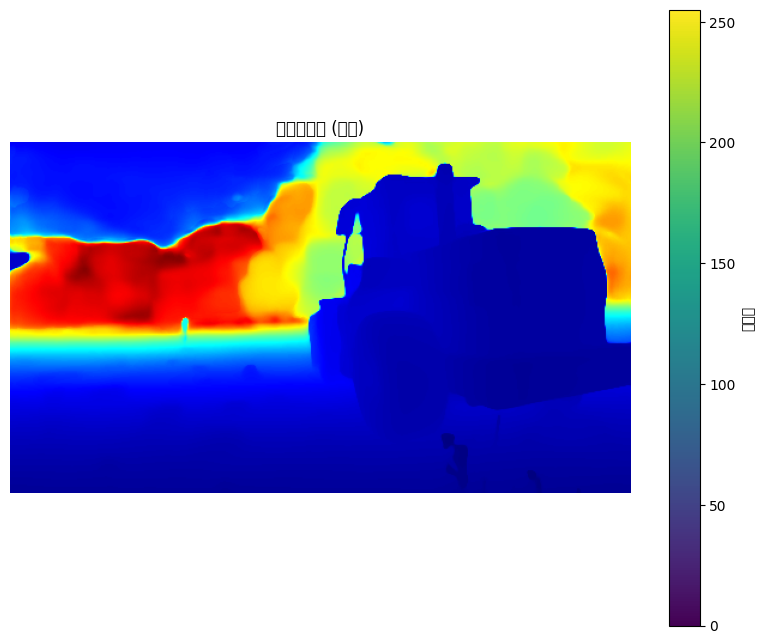

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取深度图 - 假设是16位PNG格式
depth = frame_metas[58]["depth_map"][0,...,:].numpy()  # 保持原始位深度
normalized_depth = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
depth_colored = cv2.applyColorMap(np.uint8(normalized_depth), cv2.COLORMAP_JET)
# 检查深度图属性
print(f"深度图类型: {depth.dtype}, 形状: {depth.shape}, 最小值: {depth.min()}, 最大值: {depth.max()}")

# 方法1：直接灰度显示（自动归一化）
plt.figure(figsize=(10, 8))
# plt.imshow(depth, cmap='gray')
plt.imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
plt.title('原始深度图 (灰度)')
plt.colorbar(label='深度值')
plt.axis('off')
plt.show()

In [10]:

idx=50
all_points_from_depth = torch.cat([frame["point_map_by_unprojection"] for frame in frame_metas[idx:idx+1]], dim=0).view(-1,3)
all_rgb_from_depth = torch.cat([frame["rgbs"] for frame in frame_metas[idx:idx+1]], dim=0).permute(0,2,3,1).contiguous().view(-1,3)
all_conf_from_depth = torch.cat([frame["dpt_cnf"] for frame in frame_metas[idx:idx+1]], dim=0).view(-1)
all_points_from_depth=all_points_from_depth[all_conf_from_depth>4]
all_rgb_from_depth=all_rgb_from_depth[all_conf_from_depth>4]
# random_indices = np.random.choice(len(all_points_from_depth), size=200000, replace=False)
# all_points_from_depth = all_points_from_depth[random_indices]
# all_rgb_from_depth = all_rgb_from_depth[random_indices]
o3d_points = all_points_from_depth.cpu().numpy()
o3d_colors = all_rgb_from_depth.cpu().numpy()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(o3d_points)
pcd.colors = o3d.utility.Vector3dVector(o3d_colors)
print("pcd size: ", all_points_from_depth.shape)
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/{idx}.ply", pcd)

pcd size:  torch.Size([71352, 3])


True

In [11]:
def filter_depth_by_confidence(depth, confidence, threshold=0.5):
    if confidence is None:
        return depth
    depth[confidence<threshold] = 0.0
    return depth
def convert_tensor_to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy()
    elif isinstance(tensor, np.ndarray):
        return tensor
    else:
        raise TypeError(f"Unsupported type: {type(tensor)}. Expected torch.Tensor or np.ndarray.")

def convert_tensor_rgbd_to_open3d_point_cloud(rgb, depth, intrinsic, extrinsic, confidence=None,depth_threshold=2.0):
    depth = filter_depth_by_confidence(depth, confidence, threshold=depth_threshold)
    rgb = convert_tensor_to_numpy(rgb)
    depth = convert_tensor_to_numpy(depth)
    intrinsic = convert_tensor_to_numpy(intrinsic)
    extrinsic = convert_tensor_to_numpy(extrinsic)

    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(rgb),
        o3d.geometry.Image(depth),
        depth_scale=1.0,
        depth_trunc=10,
        convert_rgb_to_intensity=False
    )
    
    intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(
        width=intrinsic.shape[1],
        height=intrinsic.shape[0],
        fx=intrinsic[0, 0],
        fy=intrinsic[1, 1],
        cx=intrinsic[0, 2],
        cy=intrinsic[1, 2]
    )
    pcd_o3d_cam = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_o3d)
    pcd_o3d_world = pcd_o3d_cam.transform(np.linalg.inv(extrinsic))

    return pcd_o3d_world

In [69]:
frame0_idx=55
frame1_idx=57
def get_data_from_metas(frame_metas, idx):
    points = torch.cat([frame["point_map_by_unprojection"] for frame in frame_metas[idx:idx+1]], dim=0)[0]
    depths = torch.cat([frame["depth_map"] for frame in frame_metas[idx:idx+1]], dim=0)[0,...,0]
    rgbs = (torch.cat([frame["rgbs"] for frame in frame_metas[idx:idx+1]], dim=0).permute(0,2,3,1).contiguous()[0] * 255.0).to(torch.uint8)
    confs = torch.cat([frame["dpt_cnf"] for frame in frame_metas[idx:idx+1]], dim=0)[0]
    K33 = frame_metas[idx]["intrinsic"][0]
    K33 = K33.reshape(3, 3)
    w2c = frame_metas[idx]["extrinsic"][0]
    ones = torch.zeros_like(w2c[0:1])
    ones[:, 3] = 1.0
    w2c = torch.cat([w2c, ones], dim=0)
    return points,depths, rgbs, confs,K33,w2c
point0,depth0, rgb0, conf0, k330, w2c0 = get_data_from_metas(frame_metas, frame0_idx)
point1,depth1, rgb1, conf1, k331, w2c1 = get_data_from_metas(frame_metas, frame1_idx)

pcd_o3d_world0 = convert_tensor_rgbd_to_open3d_point_cloud(
    rgb=rgb0,
    depth=depth0,
    intrinsic=k330,
    extrinsic=w2c0,
    confidence=conf0,
    depth_threshold=5.0
)
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/o3d_{frame0_idx}.ply", pcd_o3d_world0)
pcd_o3d_world1 = convert_tensor_rgbd_to_open3d_point_cloud(
    rgb=rgb1,
    depth=depth1,
    intrinsic=k331,
    extrinsic=w2c1,
    confidence=conf1,
    depth_threshold=5.0
)
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/o3d_{frame1_idx}.ply", pcd_o3d_world1)
def alignment_icp(source_points, target_points, init_transform=None, max_iterations=10000, tolerance=1e-6, *args, **kwargs):
    source_points.estimate_normals()
    target_points.estimate_normals()

    criteria = o3d.pipelines.registration.ICPConvergenceCriteria(
        max_iteration=max_iterations,  # 最大迭代次数
        relative_fitness=1e-6,  # 相对fitness变化
        relative_rmse=1e-6)     # 相对RMSE变化
    # print(source_points)
    result = o3d.pipelines.registration.registration_colored_icp(
        source_points, target_points,
        0.05,
        init=init_transform if init_transform is not None else np.eye(4),  # 初始变换矩阵(单位矩阵)
        # estimation_method=o3d.pipelines.registration.TransformationEstimationForColoredICP,
        criteria=criteria,
        # lambda_geometric=0.968,
        )

    return result

icp_result = alignment_icp(pcd_o3d_world1, pcd_o3d_world0, max_iterations=1000, tolerance=1e-6)
print("ICP Result:")
print(icp_result)
print("Transformation Matrix:")
print(icp_result.transformation)
pcd1_to_0 = pcd_o3d_world1.transform(icp_result.transformation)
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/o3d_{frame1_idx}_to_{frame0_idx}.ply", pcd1_to_0)
all_pcd = pcd_o3d_world0 + pcd1_to_0
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/o3d_{frame1_idx}_to_{frame0_idx}_merged.ply", all_pcd)

ICP Result:
RegistrationResult with fitness=8.326317e-01, inlier_rmse=1.545509e-02, and correspondence_set size of 56370
Access transformation to get result.
Transformation Matrix:
[[ 0.98646234 -0.04946776  0.15634897 -0.17805929]
 [ 0.04715274  0.99871667  0.0184835  -0.03630383]
 [-0.15706266 -0.01086099  0.98752892  0.00650323]
 [ 0.          0.          0.          1.        ]]


True

In [13]:
def random_down_sample_with_properties(pcd, sample_ratio=None, sample_size=None):
    n_points = len(pcd.points)
    target_size = int(n_points * sample_ratio) if sample_size is None else sample_size
    indices = np.random.choice(n_points, target_size, replace=False)
    
    # 创建新点云
    down_pcd = o3d.geometry.PointCloud()
    
    # 复制点
    down_pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points)[indices])
    
    # 复制颜色
    if pcd.has_colors():
        down_pcd.colors = o3d.utility.Vector3dVector(np.asarray(pcd.colors)[indices])
    
    # 复制法线
    if pcd.has_normals():
        down_pcd.normals = o3d.utility.Vector3dVector(np.asarray(pcd.normals)[indices])
    
    return down_pcd

In [74]:
global_pcd = None
refine_transform = [np.eye(4)]
refined_pcd = []
global_pcd_list = []
for idx in range(0, 91,1):
    cur_point, cur_depth, cur_rgb, cur_conf, cur_k33, cur_w2c = get_data_from_metas(frame_metas, idx)

    # median_conf = np.percentile(cur_conf,0.6)
    # thres_conf = min(median_conf,5.0)
    thres_conf=4.75

    cur_pcd = convert_tensor_rgbd_to_open3d_point_cloud(
        rgb=cur_rgb,
        depth=cur_depth,
        intrinsic=cur_k33,
        extrinsic=cur_w2c,
        confidence=cur_conf,
        depth_threshold=thres_conf
    )
    if global_pcd is None:
        print(f"Initializing global point cloud with frame {idx}")
        global_pcd = convert_tensor_rgbd_to_open3d_point_cloud(
            rgb=cur_rgb,
            depth=cur_depth,
            intrinsic=cur_k33,
            extrinsic=cur_w2c,
            confidence=cur_conf,
            depth_threshold=thres_conf
        )
    # cur_pcd.transform(refine_transform[-1])
    icp_result = alignment_icp(cur_pcd, global_pcd, max_iterations=1000, tolerance=1e-6, init_transform=(np.eye(4) if len(refine_transform) == 0 else refine_transform[-1]))
    # icp_result = alignment_icp(cur_pcd, global_pcd, max_iterations=1000, tolerance=1e-6, init_transform=np.eye(4))
    refine_transform.append(icp_result.transformation)
    # print(f"ICP Result for frame {idx}:")
    print(icp_result)
    print("Transformation Matrix:")
    print("threshold confidence: ", thres_conf)
    print(icp_result.transformation[:3,3])
    # global_pcd = global_pcd + cur_pcd.transform(icp_result.transformation)
    if len(icp_result.correspondence_set) < 20000:
        global_pcd =cur_pcd.transform(icp_result.transformation)
    # global_pcd_list.append(cur_pcd.transform(icp_result.transformation))
    # global_pcd = global_pcd_list[-1]+(global_pcd_list[-2] if len(global_pcd_list) > 1 else global_pcd_list[-1])
    print(f"Global point cloud size after frame {idx}: {len(global_pcd.points)}")
    if len(global_pcd.points) > 400000:
        global_pcd = random_down_sample_with_properties(global_pcd, sample_size=200000)
        print(f"Downsampled global point cloud size: {len(global_pcd.points)}")
    if idx % 10 == 0:
        o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/o3d_global_pcd_{idx}.ply", cur_pcd.transform(icp_result.transformation))

Initializing global point cloud with frame 0
RegistrationResult with fitness=1.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 53538
Access transformation to get result.
Transformation Matrix:
threshold confidence:  4.75
[0. 0. 0.]
Global point cloud size after frame 0: 53538
RegistrationResult with fitness=9.813574e-01, inlier_rmse=9.594596e-03, and correspondence_set size of 55957
Access transformation to get result.
Transformation Matrix:
threshold confidence:  4.75
[ 0.00030724 -0.00083289  0.00247508]
Global point cloud size after frame 1: 53538
RegistrationResult with fitness=8.428361e-01, inlier_rmse=9.839869e-03, and correspondence_set size of 49831
Access transformation to get result.
Transformation Matrix:
threshold confidence:  4.75
[ 0.00165596 -0.00783391 -0.00629952]
Global point cloud size after frame 2: 53538
RegistrationResult with fitness=7.603205e-01, inlier_rmse=1.354462e-02, and correspondence_set size of 47168
Access transformation to get resu

KeyboardInterrupt: 

1.0

2286

In [120]:
pcd0_to_1

PointCloud with 45174 points.

In [35]:
all_points_from_depth = torch.cat([frame["point_map_by_unprojection"] for frame in frame_metas], dim=0).view(-1,3)
all_rgb_from_depth = torch.cat([frame["rgbs"] for frame in frame_metas], dim=0).permute(0,2,3,1).contiguous().view(-1,3)
all_conf_from_depth = torch.cat([frame["dpt_cnf"] for frame in frame_metas], dim=0).view(-1)
all_points_from_depth=all_points_from_depth[all_conf_from_depth>5]
all_rgb_from_depth=all_rgb_from_depth[all_conf_from_depth>5]
random_indices = np.random.choice(len(all_points_from_depth), size=200000, replace=False)
# all_points_from_depth = all_points_from_depth[random_indices]

print("pcd size: ", all_points_from_depth.shape)

pcd size:  torch.Size([200000, 3])


In [57]:
o3d_points = all_points_from_depth.cpu().numpy()
o3d_colors = all_rgb_from_depth.cpu().numpy()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(o3d_points)
pcd.colors = o3d.utility.Vector3dVector(o3d_colors)
# o3d.visualization.draw_geometries([pcd])

In [64]:
o3d.io.write_point_cloud(f"/mnt/jfs/hengli/projects/vggt_workspace/acezero/reconstructions/icp_tnt_caterpillar/{idx}.ply", pcd)

True